<a href="https://colab.research.google.com/github/wkweigel/NotebookExamples/blob/main/3d_Alignment_and_Featurization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit py3Dmol tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.3 MB/s eta 0:00:00


In [2]:
from rdkit.Chem import AllChem, Draw, rdMolAlign, PandasTools, rdFMCS, rdMolDescriptors
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
from rdkit import RDConfig
from rdkit.Chem.FeatMaps import FeatMaps
import numpy as np
import pandas as pd
import py3Dmol
import time
import os
from tqdm.notebook import tqdm_notebook


#Define a function to align a list of mols to a reference mol and visualize them
def align_mols_to_ref(mols, ref_mol, mmff, mmff_ref):
        # create a py3Dmol object to visualize the alignment
        O3A_alignment = py3Dmol.view(width=800, height=600)
        colors=('cyanCarbon',
                'redCarbon',
                'blueCarbon',
                'aliceblueCarbon',
                'greenCarbon',
                'yellowCarbon',
                'orangeCarbon',
                'magentaCarbon',
                'purpleCarbon',
                'deeppinkCarbon')

        # Iterate over the mols and check the alignment score for each conformation
        for idx, mol in (enumerate(mols)):
            tempscore = []
            for conf_id in range(n_confs):
                O3A = rdMolAlign.GetO3A(mol, ref_mol, mmff[idx], mmff_ref, conf_id, 0)
                O3A.Align()
                tempscore.append(O3A.Score())
            bestscore = np.argmax(tempscore)

            # Add the best scoring conformation to the viewer
            IPythonConsole.addMolToView(mol,O3A_alignment,confId=int(bestscore))
        # Iterate over the mols and set thier styles in the viewer
        for idx, mol in enumerate(mols):
            O3A_alignment.setStyle({'model':idx,}, {'stick':{'colorscheme':colors[idx%len(colors)]}})
        O3A_alignment.zoomTo()
        return O3A_alignment.show()



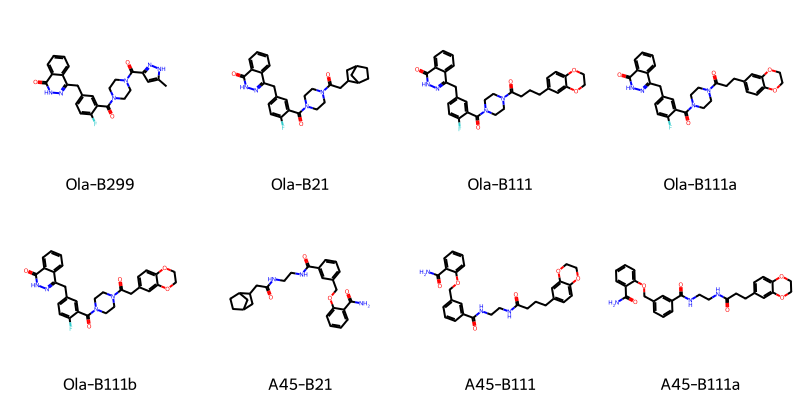

In [3]:
# Import some example smiles
smiles_file='https://raw.githubusercontent.com/wkweigel/NotebookExamples/main/Datasets/TestOlaparibLigands.csv'
smiles_df = pd.read_csv(smiles_file)
PandasTools.AddMoleculeColumnToFrame(smiles_df, "Smiles", "Structure")

# Preview the compounds
PandasTools.FrameToGridImage(smiles_df.head(8), column='Structure', legendsCol="ID", molsPerRow=4)

In [6]:
# make a new dataframe from the first 4 compounds that will be used for 3D featurization
data_df=smiles_df.iloc[:6].copy()

# specify the number of confirmations to use for the 3D alignment search
n_confs=50

# specify the conformer generator using a specific seed
p = AllChem.ETKDGv3()
p.randomSeed = 0xf00d

# Convert the smiles to mols and add them to the data_df
data_df["mols"] = [Chem.MolFromSmiles(x) for x in data_df.Smiles]

# Add H's to the mols for 3D embedding
data_df["mols"]=data_df["mols"].apply(lambda mol:Chem.AddHs(mol))

# Embed the mols using n conformations
tqdm_notebook.pandas(desc="Embedding 3d Conformers")
data_df["mols"].progress_apply(lambda mol:AllChem.EmbedMultipleConfs(mol, n_confs, p))

# Add mmff to the data_df
tqdm_notebook.pandas(desc="Appliying Forcefields")
data_df["mmff"]=data_df["mols"].progress_apply(lambda mol:AllChem.MMFFGetMoleculeProperties(mol))

Embedding 3d Conformers:   0%|          | 0/6 [00:00<?, ?it/s]

Appliying Forcefields:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
# Define a prepare a reference molecule to use for alignment
olaparib_smiles='O=C1NN=C(CC2=CC(C(N3CCN(C(C4CC4)=O)CC3)=O)=C(F)C=C2)C5=C1C=CC=C5'
ref_mol= Chem.MolFromSmiles(olaparib_smiles)
ref_mol=Chem.AddHs(ref_mol)
AllChem.EmbedMultipleConfs(ref_mol, n_confs, p)
mmff_ref = AllChem.MMFFGetMoleculeProperties(ref_mol)

In [8]:
# Align the mols in the data_df to olaparib and visualize the result
align_mols_to_ref(data_df["mols"], ref_mol, data_df["mmff"], mmff_ref )

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
#Define featurefactory from defualt base features
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

#Create dict for holding the params for each feature
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

[print(k,':',v) for k, v in fmParams.items()]



Donor : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9fb20>
Acceptor : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9eb00>
NegIonizable : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9f100>
PosIonizable : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9f4c0>
ZnBinder : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9ee90>
Aromatic : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9fe80>
Hydrophobe : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9dcc0>
LumpedHydrophobe : <rdkit.Chem.FeatMaps.FeatMaps.FeatMapParams object at 0x7eedb9e9fb50>


[None, None, None, None, None, None, None, None]

In [12]:
#Define list the features to keep for mapping
keep = ('Donor','Acceptor','NegIonizable','PosIonizable','Aromatic')

#Create the feature list
featLists = []
for mol in data_df["mols"]:
    rawFeats = fdef.GetFeaturesForMol(mol) #get the list of all features for the mol
    featLists.append([f for f in rawFeats if f.GetFamily() in keep]) # filter the full list to only include the ones in the keep list

In [13]:
from rdkit.Chem.Features.ShowFeats import _featColors as featColors

#Define functions for drawing the features
def colorToHex(rgb):
    rgb = [f'{int(255*x):x}' for x in rgb]
    return '0x'+''.join(rgb)

def drawmolfeats(m, feats, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        IPythonConsole.addMolToView(m,p,confId=confId)
        for feat in feats:
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

def drawfeatsonly(m, feats, p=None, confId=-1, removeHs=True):
        if p is None:
            p = py3Dmol.view(width=400, height=400)
        p.removeAllModels()
        if removeHs:
            m = Chem.RemoveHs(m)
        for feat in feats:
            pos = feat.GetPos()
            clr = featColors.get(feat.GetFamily(),(.5,.5,.5))
            p.addSphere({'center':{'x':pos.x,'y':pos.y,'z':pos.z},'radius':.5,'color':colorToHex(clr)});
        p.zoomTo()
        return p.show()

In [16]:
drawmolfeats(data_df["mols"][1],featLists[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
drawfeatsonly(data_df["mols"][0],featLists[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol